## Transverse field Ising Model to demo primitives
 

In [1]:

from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np 

SYGate = UnitaryGate(YGate().power(0.5), label='$\sqrt{Y}$')
SYdgGate = UnitaryGate(SYGate.inverse(), label='$\sqrt{Y}^\dagger$')



def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bit, trotter_barrier=False, layer_barrier=False):
    if num_cl_bit == 0:
        qc = QuantumCircuit(num_qubits) 
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bit)
    for i in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barrier)
        if trotter_barrier:
            qc.barrier()
    return qc



def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barrier=False): 
    
    #adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg( [i, i+1]) 
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barrier:
        qc.barrier()

    #adding Rzz in the even layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg( [i, i+1]) 
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barrier:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barrier:
        qc.barrier()

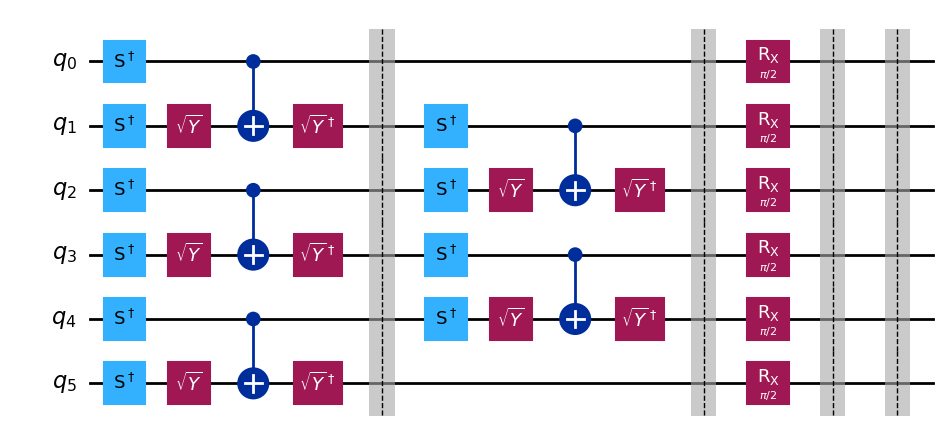

In [2]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, 0,trotter_barrier = True, layer_barrier = True)
qc.draw('mpl', fold = -1)

## Demo: Sample

In [3]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barrier=False, layer_barrier=False):
    for i in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, num_qubits, rx_angle, layer_barrier)
        if trotter_barrier:
            qc.barrier()
    return qc

def add_mirrored_1d_tfim_trotter_layer(qc, num_qubits, rx_angle, layer_barrier=False):

    qc.rx(-rx_angle, list(range(num_qubits)))
    if layer_barrier:
        qc.barrier()
    
    for i in range(1, num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([ i, i+1])
    if layer_barrier:   
        qc.barrier()

    for i in range(0, num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s( [i, i+1]) 
    if layer_barrier:
        qc.barrier()










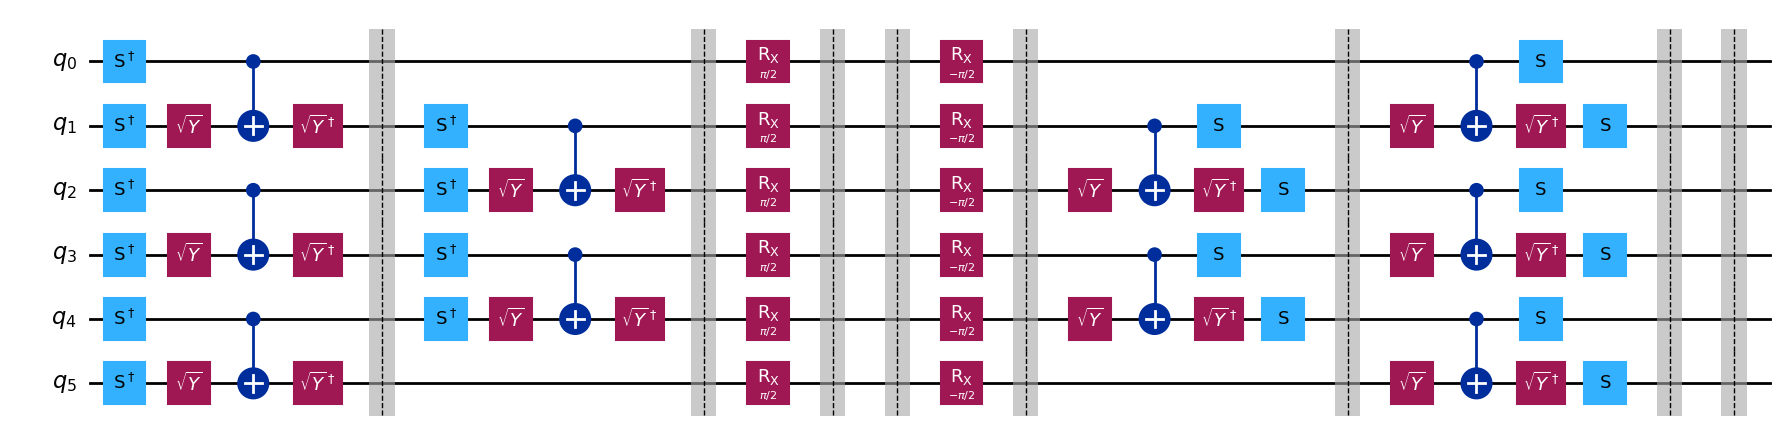

In [4]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barrier = True, layer_barrier = True)  
qc.draw(output='mpl', fold = -1)

# Step 1: Map the problem to circuits and observables


In [5]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49,50]

qc_list = []
for i in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, i, 0.5*np.pi, num_cl_bit=len(measured_qubits) , trotter_barrier = True, layer_barrier = True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, i, 0.5*np.pi, trotter_barrier = True, layer_barrier = True)
    qc.measure(measured_qubits, [0,1])  
    qc_list.append(qc)




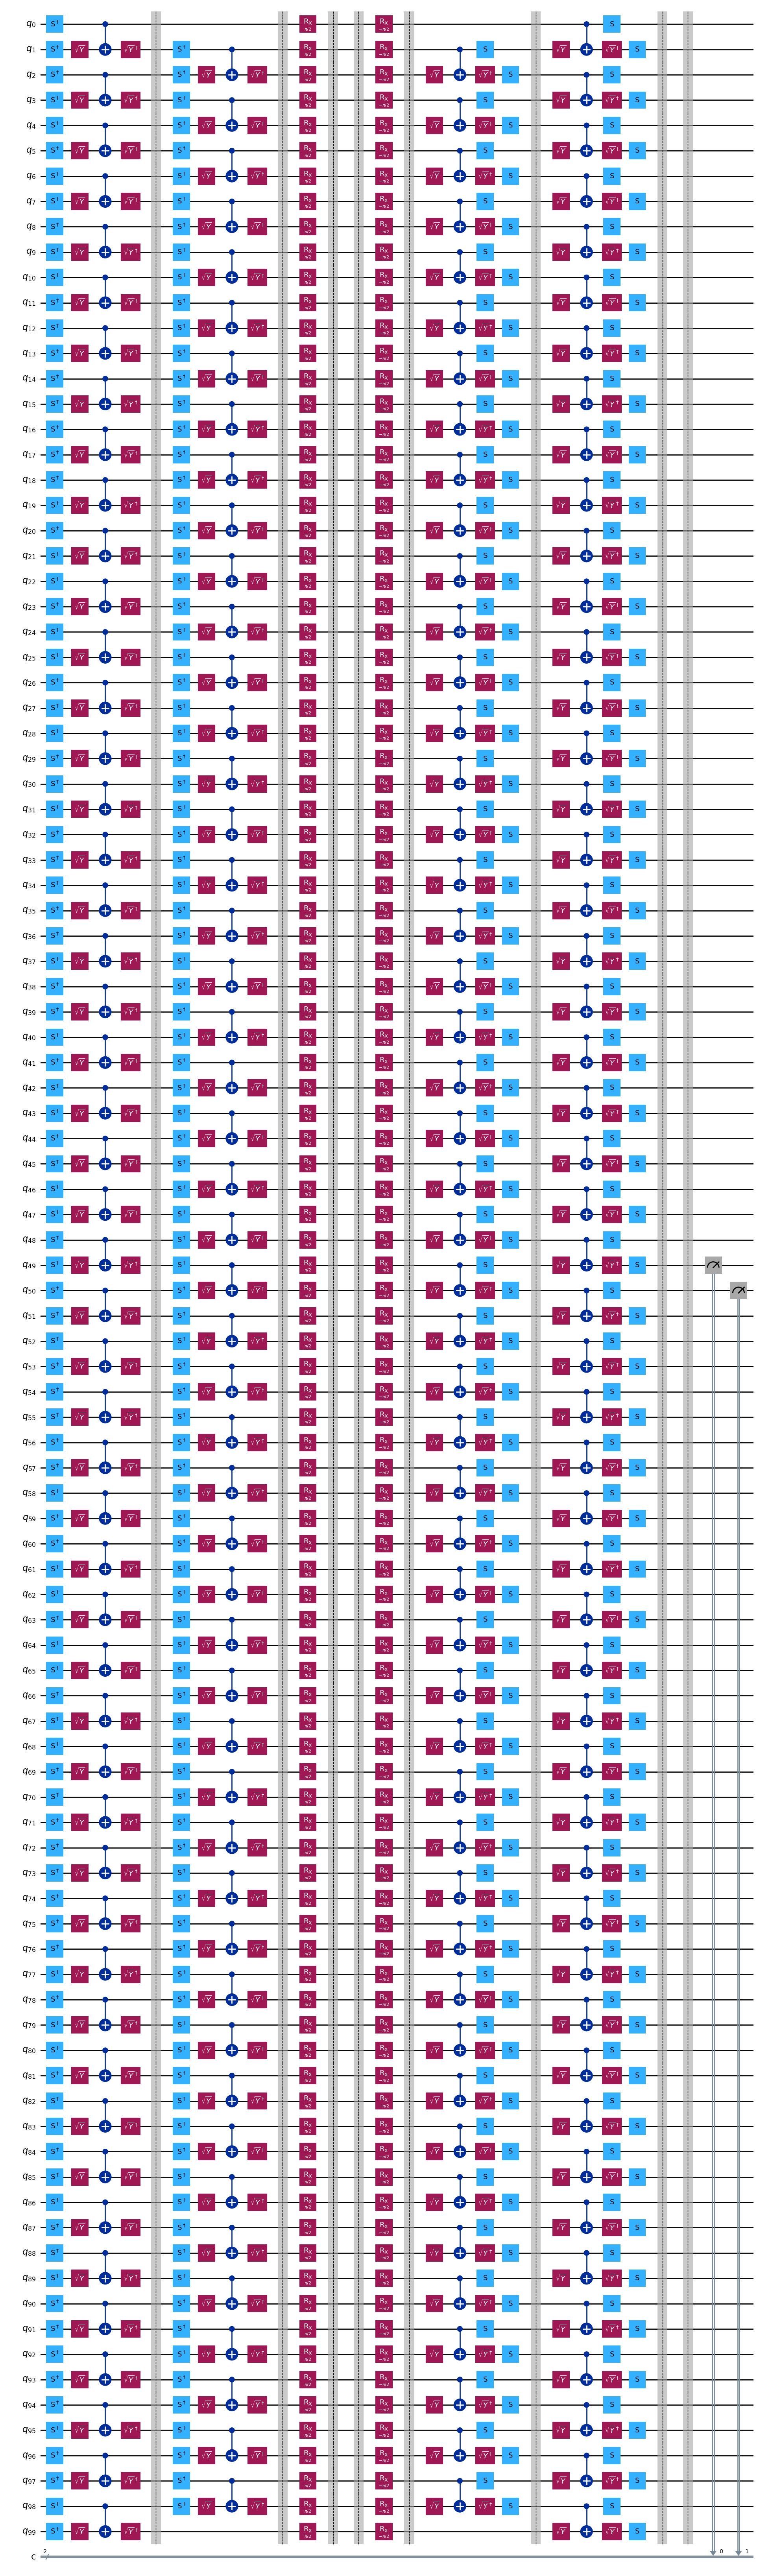

In [6]:
qc_list[1].draw(output='mpl', fold = -1)

In [7]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49,50]

qc_list = []
for i in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, i, 0.5*np.pi, num_cl_bit=len(measured_qubits) , trotter_barrier = True, layer_barrier = True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, i, 0.5*np.pi, trotter_barrier = True, layer_barrier = True)
    qc.measure(measured_qubits,list(range(len(measured_qubits))) ) 
    qc_list.append(qc)


# Step 2: Optimize

In [13]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print('Done getting backend')


qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

Done getting backend


# Step 3: Execute on hardware


In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)

sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)
print(job.job_id)



<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('cz4n73mh0kc00088wt90', 'sampler')>>


In [15]:
print(job.job_id())

cz4n73mh0kc00088wt90


# Step 4: Post-processing and plotting


In [17]:
job_id = job.job_id()
job = service.job(job_id)

survival_probability_list = []
for i in range(max_trotter_steps):
    try:
        data = job.result()[i].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)
        

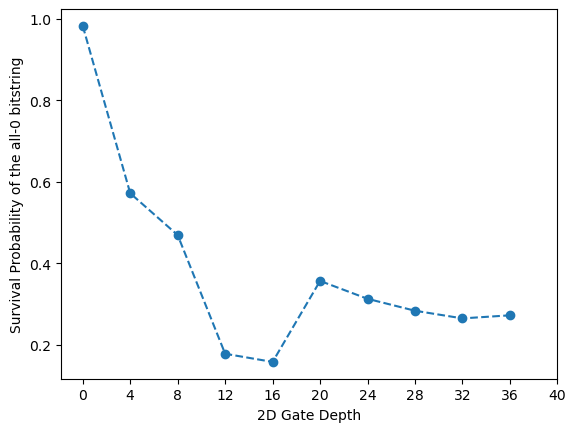

In [21]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4*max_trotter_steps,4)), survival_probability_list, '--o')
plt.xlabel('2D Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()


